In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') # change the style of the plot

import talib

### Market Returns Insights (Technical)
This notebook investigates the impact of technicals on the the S&P 500 index.

In [2]:
data = pd.read_csv('dataset.csv')
data.index = pd.to_datetime(data.index)
data.head()

,CPIAUCSL_PC1,UNRATE,FEDFUNDS,T10Y2Y,High,Low,SP500 Close,Volume,ADX,RSI,BB width
1976-06-01,5.98131,7.6,5.48,0.801364,102.507728,100.982727,101.766818,1.896500e+07,NaN,NaN,NaN
1976-07-01,5.55556,7.8,5.31,0.981905,104.933810,103.501905,104.200953,1.875048e+07,NaN,NaN,NaN
1976-08-01,5.71956,7.8,5.29,1.137273,103.985909,102.575001,103.291818,1.575818e+07,NaN,NaN,NaN
1976-09-01,5.49451,7.6,5.25,1.178095,106.130951,104.637618,105.453333,1.975000e+07,NaN,NaN,NaN
1976-10-01,5.46448,7.7,5.02,1.427000,102.681905,101.036191,101.885238,1.720905e+07,NaN,NaN,NaN


In [3]:
annual = data.resample('YS').mean()
annual['SP500 annual return'] = annual['SP500 Close'].pct_change()
# annual.head()

In [4]:
month = data.resample('MS').mean()
month['SP500 monthly return'] = month['SP500 Close'].pct_change()
# month.head()

In [5]:
# function that's used to annualize a monthly return 
def annualize(monthly):
    return round((1 + monthly) ** 12 - 1, 4)

### Average Directional Movement (ADX)
ADX values indicate the strength of a trend. 25 is the key level when we look at ADX. Low ADX (<25) is a sign of accumulation or sideway movement. There is general price agreement between the buyers and sellers. When ADX rises from below 25 to above 25, price is strong enough to continue in the direction of the breakout. There is a disagreement between the buyers and sellers on price. 

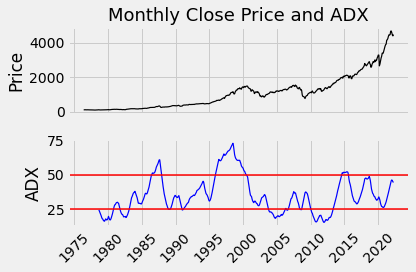

In [6]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(month['SP500 Close'], color='black', linewidth = 1.2)
ax2.set_ylabel('ADX')
ax2.plot(month['ADX'], color='blue', linewidth = 1.2)
ax1.set_title('Monthly Close Price and ADX', fontsize=18)
ax2.axhline(y = 50, color = 'r', linestyle = '-', linewidth = 1.5)
ax2.axhline(y = 25, color = 'r', linestyle = '-', linewidth = 1.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graph/ADX.png')
plt.show()

In [7]:
month['ADX level'] = np.where(month['ADX'] <= 25, 0, 
                             np.where(month['ADX'] < 50, 1, 
                                      np.where(month['ADX'].isna() == False, 3, np.nan)))

In [8]:
month['ADX level'].value_counts()

1.0    315
0.0    124
3.0     85
Name: ADX level, dtype: int64

In [9]:
month['ADX level change'] = month['ADX level'].diff()
month['ADX level change'].value_counts()

 0.0    502
 1.0      8
-1.0      7
-2.0      3
 2.0      3
Name: ADX level change, dtype: int64

In [10]:
def delay_return_ADX(lag = 1):
    a = []
    b = []
    c = []
    d = []
    for index, row in month.iterrows():
        # print(index)
        if row['ADX level change'] == 1:
            a.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['ADX level change'] == -1:
            b.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['ADX level change'] == 2:
            c.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['ADX level change'] == -2:
            d.append(month['SP500 monthly return'].shift(-lag).loc[index])
    a = [x for x in a if str(x) != 'nan']
    b = [x for x in b if str(x) != 'nan']
    c = [x for x in c if str(x) != 'nan']
    d = [x for x in d if str(x) != 'nan']
    return round(np.mean(a), 4), round(np.mean(b), 4), round(np.mean(c), 4), round(np.mean(d), 4)

In [11]:
A = {}
B = {}
C = {}
D = {}
for i in range(-6, 7):
    a, b, c, d = delay_return_ADX(i)
    A[i] = annualize(a)
    B[i] = annualize(b)
    C[i] = annualize(c)
    D[i] = annualize(d)

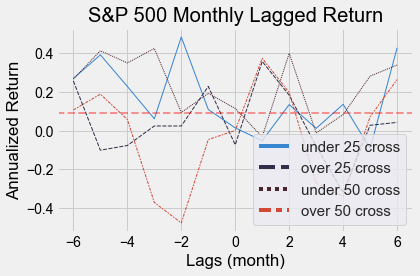

In [12]:
A = pd.DataFrame.from_dict(A, orient='index', columns=['under 25 cross'])
B = pd.DataFrame.from_dict(B, orient='index', columns=['over 25 cross'])
C = pd.DataFrame.from_dict(C, orient='index', columns=['under 50 cross'])
D = pd.DataFrame.from_dict(D, orient='index', columns=['over 50 cross'])
df = pd.concat([A, B, C, D], axis = 1)
sns.lineplot(data=df, palette="icefire", linewidth = 1)
plt.title('S&P 500 Monthly Lagged Return')
plt.axhline(round(annual['SP500 annual return'].mean(), 4), color = 'red', alpha=0.4, linestyle='--', linewidth = 2)
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel("Lags (month)")
plt.ylabel("Annualized Return")
plt.legend(loc=4, prop={'size': 15})
plt.tight_layout()
plt.savefig('Graph/S&P500 month lagged return vs ADX.png')

In [13]:
pd.concat([pd.DataFrame(df.mean(), columns=['mean']), pd.DataFrame(df.std(), columns=['std'])], axis=1)

,mean,std
under 25 cross,0.163515,0.185007
over 25 cross,0.038100,0.181219
under 50 cross,0.224131,0.161028
over 50 cross,-0.018400,0.266430


### Relative Strength Index (RSI)
RSI is an momentum indicator. An RSI that is 70 or above indicate that a stock or an index is becoming overbought or overvalued. We may be set up for a trend reversal. An RSI reading of 30 or below indicates an oversold or undervalued condition.

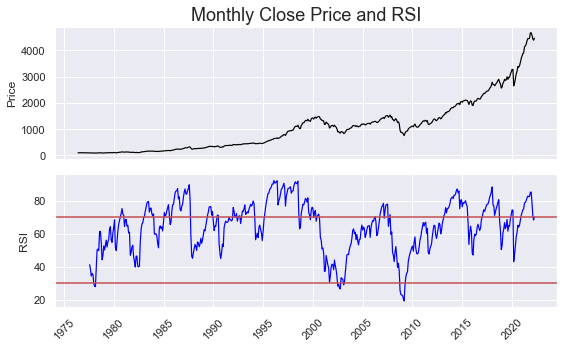

In [14]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data['SP500 Close'], color='black', linewidth = 1.2)
ax2.set_ylabel('RSI')
ax2.plot(data['RSI'], color='blue', linewidth = 1.2)
ax1.set_title('Monthly Close Price and RSI', fontsize=18)
ax2.axhline(y = 70, color = 'r', linestyle = '-', linewidth = 1.5)
ax2.axhline(y = 30, color = 'r', linestyle = '-', linewidth = 1.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graph/RSI.png')
plt.show()

In [15]:
month['RSI level'] = np.where(month['RSI'] <= 30, 0, 
                             np.where(month['RSI'] < 70, 1, 
                                      np.where(month['RSI'].isna() == False, 3, np.nan)))
month['RSI level'].value_counts()

1.0    302
3.0    220
0.0     15
Name: RSI level, dtype: int64

In [16]:
month['RSI level change'] = month['RSI level'].diff()
month['RSI level change'].value_counts()

 0.0    483
 2.0     23
-2.0     22
 1.0      4
-1.0      4
Name: RSI level change, dtype: int64

In [17]:
def delay_return_RSI(lag = 1):
    a = []
    b = []
    c = []
    d = []
    for index, row in month.iterrows():
        # print(index)
        if row['RSI level change'] == 1:
            a.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['RSI level change'] == -1:
            b.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['RSI level change'] == 2:
            c.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['RSI level change'] == -2:
            d.append(month['SP500 monthly return'].shift(-lag).loc[index])
    a = [x for x in a if str(x) != 'nan']
    b = [x for x in b if str(x) != 'nan']
    c = [x for x in c if str(x) != 'nan']
    d = [x for x in d if str(x) != 'nan']
    return round(np.mean(a), 4), round(np.mean(b), 4), round(np.mean(c), 4), round(np.mean(d), 4)

In [18]:
A = {}
B = {}
C = {}
D = {}
for i in range(-6, 7):
    a, b, c, d = delay_return_RSI(i)
    A[i] = annualize(a)
    B[i] = annualize(b)
    C[i] = annualize(c)
    D[i] = annualize(d)

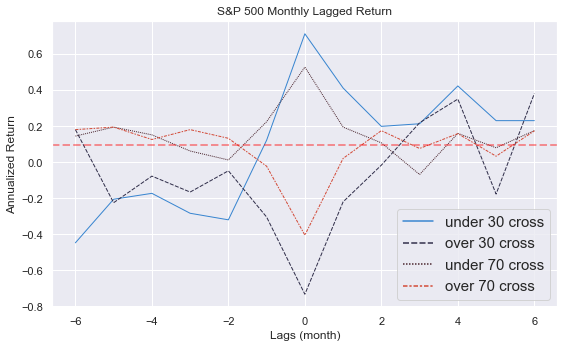

In [19]:
A = pd.DataFrame.from_dict(A, orient='index', columns=['under 30 cross'])
B = pd.DataFrame.from_dict(B, orient='index', columns=['over 30 cross'])
C = pd.DataFrame.from_dict(C, orient='index', columns=['under 70 cross'])
D = pd.DataFrame.from_dict(D, orient='index', columns=['over 70 cross'])
df = pd.concat([A, B, C, D], axis = 1)
sns.lineplot(data=df, palette="icefire", linewidth = 1)
plt.title('S&P 500 Monthly Lagged Return')
plt.axhline(round(annual['SP500 annual return'].mean(), 4), color = 'red', alpha=0.4, linestyle='--', linewidth = 2)
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel("Lags (month)")
plt.ylabel("Annualized Return")
plt.legend(loc=4, prop={'size': 15})
plt.tight_layout()
plt.savefig('Graph/S&P500 month lagged return vs RSI.png')

In [20]:
pd.concat([pd.DataFrame(df.mean(), columns=['mean']), pd.DataFrame(df.std(), columns=['std'])], axis=1)

,mean,std
under 30 cross,0.085254,0.343876
over 30 cross,-0.064515,0.301103
under 70 cross,0.150838,0.139509
over 70 cross,0.078462,0.161460


### Bollinger Bands Width
The bollinger bands width is calculated by subtracting the values of the lower band from the upper band and then divided by the value of the middle band which is the 20-period MA. During a period of rising price volatility, the distance between the two bands will widen and Bollinger Band Width will increase. Conversely, during a period of low market volatility, the distance between the two bands will contract and Bollinger Band Width will decrease. When the bands are relatively far apart, that is often a sign that the current trend may be ending.

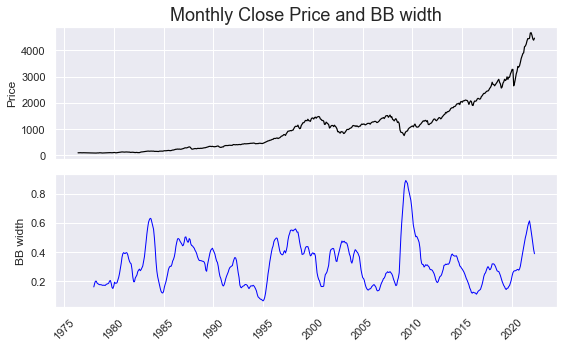

In [21]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data['SP500 Close'], color='black', linewidth = 1.2)
ax2.set_ylabel('BB width')
ax2.plot(data['BB width'], color='blue', linewidth = 1)
# ax2.axhline(y = 0.15, color = 'r', linestyle = '-', linewidth = 1.5)
# ax2.axhline(y = 0.6, color = 'r', linestyle = '-', linewidth = 1.5)
ax1.set_title('Monthly Close Price and BB width', fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graph/BB width.png')
plt.show()

In [22]:
month['BBW level'] = np.where(month['BB width'] <= 0.15, 0, 
                             np.where(month['BB width'] < 0.6, 1, 
                                      np.where(month['BB width'].isna() == False, 3, np.nan)))
month['BBW level'].value_counts()

1.0    474
0.0     39
3.0     19
Name: BBW level, dtype: int64

In [23]:
month['BBW level change'] = month['BBW level'].diff()
month['BBW level change'].value_counts()

 0.0    513
 1.0      6
-1.0      6
-2.0      3
 2.0      3
Name: BBW level change, dtype: int64

In [24]:
def delay_return_BBW(lag = 1):
    a = []
    b = []
    c = []
    d = []
    for index, row in month.iterrows():
        # print(index)
        if row['BBW level change'] == 1:
            a.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['BBW level change'] == -1:
            b.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['BBW level change'] == 2:
            c.append(month['SP500 monthly return'].shift(-lag).loc[index])
        elif row['BBW level change'] == -2:
            d.append(month['SP500 monthly return'].shift(-lag).loc[index])
    a = [x for x in a if str(x) != 'nan']
    b = [x for x in b if str(x) != 'nan']
    c = [x for x in c if str(x) != 'nan']
    d = [x for x in d if str(x) != 'nan']
    return round(np.mean(a), 4), round(np.mean(b), 4), round(np.mean(c), 4), round(np.mean(d), 4)

In [25]:
A = {}
B = {}
C = {}
D = {}
for i in range(-6, 7):
    a, b, c, d = delay_return_BBW(i)
    A[i] = annualize(a)
    B[i] = annualize(b)
    C[i] = annualize(c)
    D[i] = annualize(d)

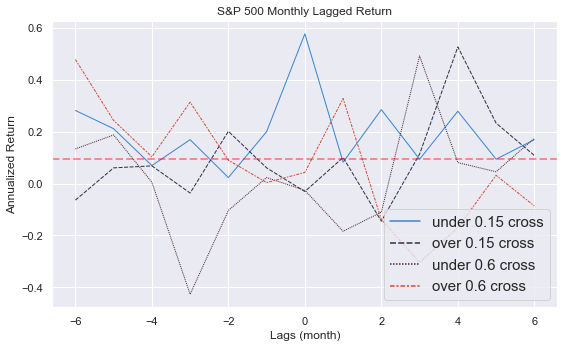

In [26]:
A = pd.DataFrame.from_dict(A, orient='index', columns=['under 0.15 cross'])
B = pd.DataFrame.from_dict(B, orient='index', columns=['over 0.15 cross'])
C = pd.DataFrame.from_dict(C, orient='index', columns=['under 0.6 cross'])
D = pd.DataFrame.from_dict(D, orient='index', columns=['over 0.6 cross'])
df = pd.concat([A, B, C, D], axis = 1)
sns.lineplot(data=df, palette="icefire", linewidth = 1)
plt.title('S&P 500 Monthly Lagged Return')
plt.axhline(round(annual['SP500 annual return'].mean(), 4), color = 'red', alpha=0.4, linestyle='--', linewidth = 2)
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel("Lags (month)")
plt.ylabel("Annualized Return")
plt.legend(loc=4, prop={'size': 15})
plt.tight_layout()
plt.savefig('Graph/S&P500 month lagged return vs BBW.png')

In [27]:
pd.concat([pd.DataFrame(df.mean(), columns=['mean']), pd.DataFrame(df.std(), columns=['std'])], axis=1)

,mean,std
under 0.15 cross,0.194892,0.144025
over 0.15 cross,0.091938,0.167474
under 0.6 cross,0.022308,0.217481
over 0.6 cross,0.071831,0.222912
